In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse

In [2]:
train = pd.read_parquet('data/train.par')
test = pd.read_parquet('data/test.par')
items = pd.read_parquet('data/items.par')

In [3]:
items.drop_duplicates(subset=['item_id'], inplace=True)

In [4]:
n_users = train.user_id.max() + 1
n_items = train.item_id.max() + 1

In [5]:
test_1 = train.groupby('user_id').sample(frac=0.1)
train_1 = train[~train.index.isin(test_1.index)]

In [6]:
train_ratings = train_1 \
    .groupby(['item_id', 'user_id'], as_index=False) \
    .size() \
    .rename(columns={'size': 'rating'})

user_sum_rating = train_ratings.groupby('user_id').rating.sum()
train_ratings = train_ratings.join(user_sum_rating, on='user_id', rsuffix='_sum')
train_ratings['rating_normal'] = train_ratings['rating'] / train_ratings['rating_sum']

In [7]:
confidence = 1.0 + train_ratings.rating_normal.values * 30.0

rating_matrix = sparse.csr_matrix(
    (
        confidence, 
        (
            train_ratings.item_id.values,
            train_ratings.user_id.values
        )
    ),
    shape=(n_items, n_users)
)

rating_matrix_T = sparse.csr_matrix(
    (
        np.full(rating_matrix.nnz, 1), 
        (
            train_ratings.user_id.values,
            train_ratings.item_id.values
        )
    ),
    shape=(n_users, n_items)
)

In [8]:
import implicit

als = implicit.als.AlternatingLeastSquares(factors=128, 
                                           calculate_training_loss=True, 
                                           iterations=100)

als.fit(rating_matrix)

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
import joblib

def predict_als_for_user(user_id):
    recommendations = als.recommend(user_id, rating_matrix_T, N=100)
    recommended_items = [x for x, _ in recommendations]
    recommended_scores = [x for _, x in recommendations]
    return user_id, recommended_items, recommended_scores

als_prediction_raw = joblib.Parallel(backend='multiprocessing', verbose=1, n_jobs=32)(
    joblib.delayed(predict_als_for_user)(u) for u in train.user_id.unique()
)

als_prediction = pd.DataFrame(als_prediction_raw, columns=['user_id', 'item_id', 'score'])

[Parallel(n_jobs=32)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 1224 tasks      | elapsed:    2.8s
[Parallel(n_jobs=32)]: Done 2624 tasks      | elapsed:    6.3s
[Parallel(n_jobs=32)]: Done 4424 tasks      | elapsed:   10.9s
[Parallel(n_jobs=32)]: Done 6624 tasks      | elapsed:   16.7s
[Parallel(n_jobs=32)]: Done 9224 tasks      | elapsed:   23.1s
[Parallel(n_jobs=32)]: Done 12224 tasks      | elapsed:   31.0s
[Parallel(n_jobs=32)]: Done 13490 out of 13490 | elapsed:   34.6s finished


In [10]:
import my_metrics

print('Full:', my_metrics.compute(als_prediction, test))
print('Test_1:', my_metrics.compute(als_prediction, test_1))

Full: {'recall': 0.1289152458611317, 'map': 0.08272440490898608}
Test_1: {'recall': 0.057040635626625244, 'map': 0.026369100883496466}


In [11]:
user2als_prediction = als_prediction.set_index('user_id')


def samples_to_df(user_id, positive_samples: list, negative_samples: list) -> pd.DataFrame:
    positive = pd.DataFrame({
        'user_id': user_id,
        'item_id': positive_samples,
    }).explode('item_id')
    positive['label'] = 1

    negative = pd.DataFrame({
        'user_id': user_id,
        'item_id': negative_samples,
    }).explode('item_id')
    negative['label'] = 0

    samples = pd.concat([
        positive,
        negative
    ])
    samples['user_id'] = samples.user_id.values.astype(np.int64)
    samples['item_id'] = samples.item_id.values.astype(np.int64)

    return samples


def generate_samples_for_user(user_id):
    candidates = set(np.array(user2als_prediction.loc[user_id].item_id))
    valid = set(test_1[test_1.user_id == user_id].item_id.values)
    positive_samples = list(candidates.intersection(valid))
    negative_samples = list(candidates.difference(valid))

    features = samples_to_df(user_id, positive_samples, negative_samples)
    
    item_ids = features.item_id.values
    scores = als.item_factors[item_ids] @ als.user_factors[user_id]
    features['score'] = scores
    features['rank'] = features['score'].rank(method='dense')

    return features

stage2_samples = joblib.Parallel(backend='multiprocessing', verbose=1, n_jobs=32)(
    joblib.delayed(generate_samples_for_user)(id) for id in train.user_id.unique()
)

all_samples = pd.concat(stage2_samples)
all_samples = all_samples.sample(n=len(all_samples))

[Parallel(n_jobs=32)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 4096 tasks      | elapsed:    1.3s
[Parallel(n_jobs=32)]: Done 13312 tasks      | elapsed:    3.7s
[Parallel(n_jobs=32)]: Done 13490 out of 13490 | elapsed:    3.8s finished


In [12]:
all_samples

,user_id,item_id,label,score,rank
91,1656,42471,0,0.040552,26.0
36,9443,31577,0,0.050149,51.0
2,12797,11269,0,0.191473,29.0
86,2786,24039,0,0.086491,79.0
30,1786,16981,0,0.060783,27.0
...,...,...,...,...,...
29,13360,26181,0,0.028021,20.0
26,448,9271,0,0.126112,58.0
57,6129,46253,0,0.075923,37.0
68,3791,17322,0,0.065888,3.0


In [13]:
from sklearn.model_selection import train_test_split

selected_features = [
    'score',
    'rank',
]
selected_cat_features = []

all_features = all_samples[selected_features + ['label']]
all_features_X = all_features.drop(columns=['label'])
all_features_Y = all_features[['label']]
X_train, X_test, y_train, y_test = train_test_split(all_features_X, all_features_Y, test_size=0.3)

value_count_01 = y_train.value_counts()
w0 = value_count_01[0] / len(y_train)
w1 = value_count_01[1] / len(y_train)
print('w_0 =', w0)
print('w_1 =', w1)

w_0 = 0.9905940908609552
w_1 = 0.009405909139044795


In [14]:
from catboost import Pool as CatBoostPool
from catboost import CatBoostClassifier
from catboost.metrics import BalancedAccuracy 
from catboost.metrics import Logloss 

cb_train_pool = CatBoostPool(X_train, y_train, cat_features=selected_cat_features)
cb_test_pool = CatBoostPool(X_test, y_test, cat_features=selected_cat_features)

cb_params = {
    'n_estimators': 500,
    'depth': 6,
    'class_weights': [w1, w0], 
    'objective': Logloss(), 
    'eval_metric': BalancedAccuracy(),
    'early_stopping_rounds': 50,
    'learning_rate': 0.1
}
cb_classifier = CatBoostClassifier(**cb_params)
cb_classifier.fit(cb_train_pool, eval_set=cb_test_pool)

0:	learn: 0.7188761	test: 0.7199753	best: 0.7199753 (0)	total: 80.8ms	remaining: 40.3s
1:	learn: 0.7188761	test: 0.7199753	best: 0.7199753 (0)	total: 107ms	remaining: 26.7s
2:	learn: 0.7188761	test: 0.7199753	best: 0.7199753 (0)	total: 131ms	remaining: 21.7s
3:	learn: 0.7182200	test: 0.7213979	best: 0.7213979 (3)	total: 157ms	remaining: 19.4s
4:	learn: 0.7195811	test: 0.7217798	best: 0.7217798 (4)	total: 184ms	remaining: 18.2s
5:	learn: 0.7195811	test: 0.7217798	best: 0.7217798 (4)	total: 209ms	remaining: 17.2s
6:	learn: 0.7196971	test: 0.7219332	best: 0.7219332 (6)	total: 234ms	remaining: 16.5s
7:	learn: 0.7188217	test: 0.7230870	best: 0.7230870 (7)	total: 256ms	remaining: 15.8s
8:	learn: 0.7202794	test: 0.7224495	best: 0.7230870 (7)	total: 279ms	remaining: 15.2s
9:	learn: 0.7202457	test: 0.7220043	best: 0.7230870 (7)	total: 308ms	remaining: 15.1s
10:	learn: 0.7202575	test: 0.7219145	best: 0.7230870 (7)	total: 332ms	remaining: 14.7s
11:	learn: 0.7202105	test: 0.7224308	best: 0.7230870

[('score', 93.98751780487117), ('rank', 6.012482195128832)]


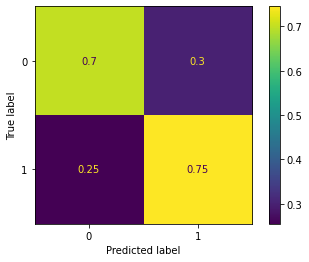

In [15]:
print(sorted(zip(X_train.columns, cb_classifier.feature_importances_), key=lambda x: -x[1]))

cb_predictions = cb_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, cb_predictions, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [16]:
cb_params.update({ 'n_estimators': 15 })
cb_classifier_final = CatBoostClassifier(**cb_params)
cb_final_pool = CatBoostPool(all_features_X, all_features_Y, cat_features=selected_cat_features)
cb_classifier_final.fit(cb_final_pool)

0:	learn: 0.7192046	total: 27.8ms	remaining: 390ms
1:	learn: 0.7192046	total: 52.4ms	remaining: 340ms
2:	learn: 0.7192046	total: 76.5ms	remaining: 306ms
3:	learn: 0.7199825	total: 100ms	remaining: 275ms
4:	learn: 0.7202615	total: 123ms	remaining: 247ms
5:	learn: 0.7199432	total: 146ms	remaining: 220ms
6:	learn: 0.7202505	total: 172ms	remaining: 197ms
7:	learn: 0.7199717	total: 195ms	remaining: 171ms
8:	learn: 0.7202220	total: 218ms	remaining: 145ms
9:	learn: 0.7204388	total: 242ms	remaining: 121ms
10:	learn: 0.7205988	total: 264ms	remaining: 96ms
11:	learn: 0.7205988	total: 287ms	remaining: 71.9ms
12:	learn: 0.7208633	total: 310ms	remaining: 47.7ms
13:	learn: 0.7208318	total: 333ms	remaining: 23.8ms
14:	learn: 0.7208682	total: 404ms	remaining: 0us


In [17]:
seen_items = train.groupby('user_id').agg({'item_id': set}).item_id

def filter_seen_items(user_id, recommended_items):
    user_seen_items = seen_items.loc[user_id]
    final_recommended_items = []
    for i in recommended_items:
        if i not in user_seen_items:
            final_recommended_items.append(i)
    return final_recommended_items


def features2recomendations(user_id, recommended_items, features):
    probs = cb_classifier_final.predict_proba(features, thread_count=1)[:, 1]
    ranks = np.argsort(-probs)
    filtered_items = filter_seen_items(user_id, recommended_items[ranks])
    return filtered_items 


def predict_als_catboost_for_user(user_id):
    recomendations = als.recommend(user_id, rating_matrix_T, N=100)
    recommended_items = np.array([x for x, _ in recomendations])
    recommended_scores = np.array([x for _, x in recomendations])
    recommended_ranks = np.argsort(recommended_scores) + 1

    features = pd.DataFrame({
        'score': recommended_scores,
        'rank': recommended_ranks
    })[selected_features]

    final_recomendations = features2recomendations(user_id, recommended_items, features)
    return user_id, final_recomendations


als_catboost_prediction = joblib.Parallel(backend='multiprocessing', verbose=1, n_jobs=32)(
    joblib.delayed(predict_als_catboost_for_user)(u) for u in test_1.user_id.unique()
)

als_catboost_prediction = pd.DataFrame(als_catboost_prediction, columns=['user_id', 'item_id'])

[Parallel(n_jobs=32)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 1224 tasks      | elapsed:    2.4s
[Parallel(n_jobs=32)]: Done 2624 tasks      | elapsed:    4.9s
[Parallel(n_jobs=32)]: Done 4424 tasks      | elapsed:    7.9s
[Parallel(n_jobs=32)]: Done 6624 tasks      | elapsed:   11.4s
[Parallel(n_jobs=32)]: Done 9224 tasks      | elapsed:   15.2s
[Parallel(n_jobs=32)]: Done 12224 tasks      | elapsed:   19.6s
[Parallel(n_jobs=32)]: Done 13427 out of 13490 | elapsed:   21.5s remaining:    0.1s
[Parallel(n_jobs=32)]: Done 13490 out of 13490 | elapsed:   21.5s finished


In [18]:
my_metrics.compute(als_catboost_prediction, test)

{'recall': 0.1321917469730665, 'map': 0.0896684492922447}